In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

from obspy.core.trace import Trace, Stats
from obspy.core.stream import Stream
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

from obspy.imaging.beachball import beachball
from obspy.imaging.beachball import beach
from obspy.imaging.source import plot_radiation_pattern

from matplotlib.patches import Rectangle
from matplotlib.offsetbox import AnchoredText
import matplotlib.patches
from matplotlib.pyplot import cm
from matplotlib import cycler


from matplotlib.gridspec import GridSpec

client = Client("IRIS")

In [2]:
def waveforms(start, end, adjtime):
    st_raw = client.get_waveforms("XB", "ELYSE", "02", "B*", start-(adjtime/2), end+adjtime, attach_response=True)
    st_disp = st_raw.copy()
    st_disp.remove_response(output='DISP')
    st_disp.filter('bandpass',freqmin=0.125, freqmax=1.0,corners=4, zerophase=True)
    return st_disp

def rotate(c1,c2,a):
    """
    IN: c1,c2 (arrays) and a (angle)
    c1 c2 are the X and Y axes, respectively of a Cartesian coordinate system
    a is an angle in degrees, positive angle means a clockwise rotation of the coordinate system.
    OUT: o1, o2 (arrays)
    o1 o2 are the X and Y axes, respectively of a rotated Cartesian coordinate system
    """
    o1 = np.cos(np.radians(a))*c1 - np.sin(np.radians(a))*c2
    o2 = np.sin(np.radians(a))*c1 + np.cos(np.radians(a))*c2
    return o1, o2

def uvw2enz(st,angles):
    BAz = angles[0]
    Pincd = angles[1]
    Sincd = angles[2]
    
    if len(st) != 3:
       print('Stream does not contain 3 Traces')
       return st
    for trace in st:
        head = trace.stats
        channel = head.channel
        if channel == 'BHU': U = trace.data
        elif channel == 'BHV': V = trace.data
        elif channel == 'BHW': W = trace.data
        else:
            print('Trace.channel is not BHU, BHV, or BHW')
            return st

    d = np.radians(-30)
    aU = np.radians(135)
    aV = np.radians(15)
    aW = np.radians(255)

    A = np.array([[np.cos(d)*np.sin(aU),np.cos(d)*np.cos(aU),-np.sin(d)],
                  [np.cos(d)*np.sin(aV), np.cos(d)*np.cos(aV), -np.sin(d)],
                  [np.cos(d)*np.sin(aW), np.cos(d)*np.cos(aW), -np.sin(d)]])

    B = np.linalg.inv(A)
    E,N,Z = np.dot(B,(U,V,W))

    head.channel = 'BHE'; trE = Trace(data=E, header=head)
    head.channel = 'BHN'; trN = Trace(data=N, header=head)
    head.channel = 'BHZ'; trZ = Trace(data=Z, header=head)
    stENZ = Stream(traces=[trE,trN,trZ])
    
    hhe = stENZ[0].data
    hhn = stENZ[1].data
    hhz = stENZ[2].data
    
    hhT,hhR = rotate(trE,trN,BAz)
    head.channel = 'BHT'; trT = Trace(data=hhT, header=head)
    head.channel = 'BHR'; trR = Trace(data=hhR, header=head)
    
    phhQ,phhL = rotate(trR,trZ,Pincd)
    shhQ,shhL = rotate(trR,trZ,Sincd)
    head.channel = 'BHL'; trL = Trace(data=phhL, header=head)
    head.channel = 'BHQ'; trQ = Trace(data=shhQ, header=head)
    
    stALL = Stream(traces=[trE,trN,trZ,trT,trR,trL,trQ])
    
    return stALL

In [3]:
s0235b_fwd = pd.read_csv('./fwdcalc/fwdcalc-235b.csv', header=None)
s0173a_fwd = pd.read_csv('./fwdcalc/fwdcalc-173a.csv', header=None)
s0173ab_fwd = pd.read_csv('./fwdcalc/fwdcalc-173ab.csv',header=None)
s0325ab_fwd = pd.read_csv('./fwdcalc/fwdcalc-325ab.csv',header=None)

for amps in [s0235b_fwd,s0173a_fwd,s0173ab_fwd,s0325ab_fwd]:
    amps.columns = ['ModIndex','Model','Depth','Strike', 'Dip', 'Rake', 'P', 'SV', 'SH']

(155.0, 180.0)

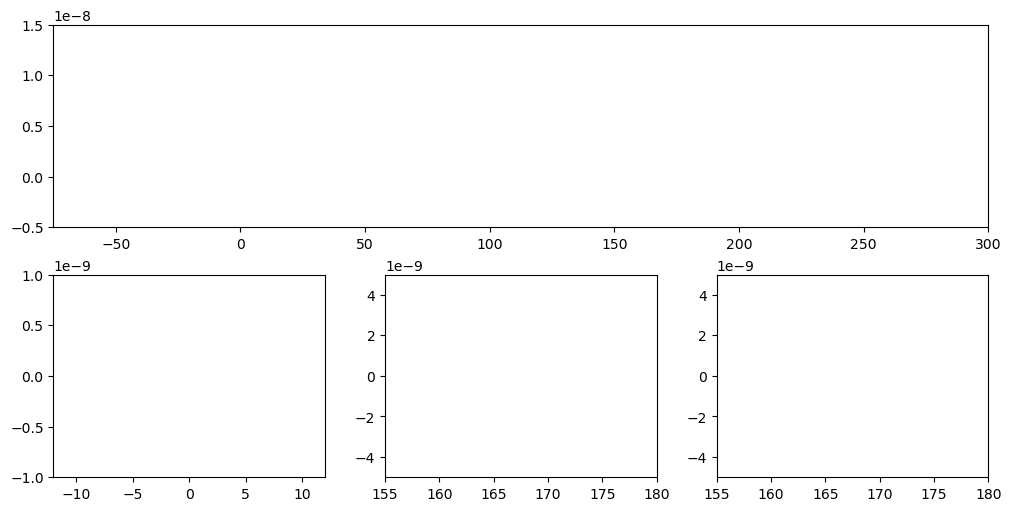

In [4]:
fig = plt.figure(figsize=(10,5),constrained_layout=True,frameon=False)

gs = GridSpec(2,3, figure = fig)
ax1 = fig.add_subplot(gs[0,:]); ax1.set_ylim(-5e-9,15e-9); ax1.set_xlim(-75,300)

ax2 = fig.add_subplot(gs[1, 0:1]); ax2.set_ylim(-1e-9,1e-9); ax2.set_xlim(-12,12)

ax3 = fig.add_subplot(gs[1, 1:2]); ax3.set_ylim(-5e-9,5e-9); ax3.set_xlim(155,180)
ax4 = fig.add_subplot(gs[1, 2:3]); ax4.set_ylim(-5e-9,5e-9); ax4.set_xlim(155,180)


In [5]:
def paper_plot(st,df,Pt,St,angs,Ptime=0):
    if Ptime == 0: Ptime = st[0].stats.starttime
    time_axis = st[0].times(reftime=Ptime)
    n = min([len(time_axis)]+[len(st[i].data) for i in np.arange(len(st))])

    sENZ = uvw2enz(st,angs)
    shift = 5; a = 1e-9
    
    ### FIG PARAM ###
    fig = plt.figure(figsize=(10,5),constrained_layout=True,frameon=False)
    colors = cycler('color',
                    ['#66c2a6', '#fc8d62',
                     '#8ea0cb', '#e889c3', '#a6d855'])
    plt.rc('axes', facecolor='#F6F6F6', edgecolor='none',
           axisbelow=True, grid=True, prop_cycle=colors)
    plt.rc('grid', color='w', linestyle='solid')
    plt.rc('xtick', color='grey', direction='out', labelsize='small'); plt.rc('ytick', color='grey', direction='out', labelsize='x-small')
    fig.patch.set_facecolor('white')
    
    fig.text(0.5,0.475, "time after $P$-wave arrival (s)", ha="center", va="center_baseline", color ='grey',fontsize='small')
    fig.text(0.01,0.65, "Displacement (nm)", rotation=90, color='grey',fontsize='small')
    cms = AnchoredText("plot design\nMaddy Sita", loc="lower right", borderpad=0, frameon=False, prop=dict(size=6,alpha=0.1))
    cms.set_zorder(0)
    

    ### SUBPLOT PARAM ###
    gs = GridSpec(2,3, figure = fig)
    ax1 = fig.add_subplot(gs[0,:]); ax1.set_ylim(-5e-9,15e-9); ax1.set_xlim(-75,475)
    ax1.tick_params(labelleft=False, length=0)

    ax2 = fig.add_subplot(gs[1, 0:1])
    ax2.set_ylim(-2e-9,2e-9); ax2.set_xlim(-12,12)
    ax2.set_yticks([-1.5e-9,-0.75e-9,0,0.75e-9,1.5e-9])
    
    ax3 = fig.add_subplot(gs[1, 1:2]) 
    ax3.set_ylim(-5e-9,5e-9); ax3.set_xlim(St-11,St+11)
    
    ax4 = fig.add_subplot(gs[1, 2:3]); ax4.add_artist(cms)
    ax4.set_ylim(-5e-9,5e-9); ax4.set_xlim(St-11,St+11)

    
    ### SUBPLOT ANNOTATIONS ###
    ax1.vlines(Pt,-6*a,16*a,color='k',linestyle='--',lw = 0.75,alpha=0.5)
    ax1.annotate('P', xy=(Pt-6,-3*a), size='medium', color='k')
    ax1.vlines(St,-6*a,16*a,color='k',linestyle='--',lw = 0.75,alpha=0.5)
    ax1.annotate('S', xy=(St-6,-3*a), size='medium', color='k')
    
    ax2.vlines(Pt,-6*a,16*a,color='k',linestyle='--',lw = 0.75,alpha=0.5)
    ax2.errorbar(Pt-7, 0, yerr=1.13e-10, capsize=4, ecolor='k', elinewidth=1)
    
    ax3.vlines(St,-6*a,16*a,color='k',linestyle='--',lw = 0.75,alpha=0.5)
    ax3.errorbar(St-7, 0, yerr=1.46e-10, capsize=4, ecolor='k', elinewidth=1)

    
    ax4.vlines(St,-6*a,16*a,color='k',linestyle='--',lw = 0.75,alpha=0.5)
    ax4.errorbar(St-7, 0, yerr=2.01e-10, capsize=4, ecolor='k', elinewidth=1)

    
    for trace in sENZ:
    #### ENZ ####
        if trace.stats.channel == 'BHZ':
            ax1.plot(time_axis[:n], trace.data[:n], lw=1.5, label = trace.stats.channel)
            ax1.annotate('BHZ', xy=(Pt-30,0.5*a), size='small', color='k')
        if trace.stats.channel == 'BHN':
            ax1.plot(time_axis[:n], trace.data[:n] + shift*a, lw=1.5, label = trace.stats.channel)
            ax1.annotate('BHN', xy=(Pt-30,5.5*a), size='small', color='k')
        if trace.stats.channel == 'BHE':
            ax1.plot(time_axis[:n], trace.data[:n] + 2*shift*a, lw=1.5, label = trace.stats.channel)
            ax1.annotate('BHE', xy=(Pt-30,10.5*a), size='small', color='k')
            
    #### P - BHL ####
        if trace.stats.channel == 'BHL':
            ax2.plot(time_axis[:n], trace.data[:n], lw=1, label = trace.stats.channel,color = 'k')
            ax2.annotate('BHL', xy=(Pt-8,1*a), size='small', color='k')
            
    #### SH - BHL ####
        if trace.stats.channel == 'BHT':
            ax3.plot(time_axis[:n], trace.data[:n], lw=1, label = trace.stats.channel, color='k')
            ax3.annotate('BHT', xy=(St-8,2.5*a), size='small', color='k')
            
    #### SV - BHL ####
        if trace.stats.channel == 'BHQ':
            ax4.plot(time_axis[:n], trace.data[:n], lw=1, label = trace.stats.channel, color='k')
            ax4.annotate('BHQ', xy=(St-8,2.5*a), size='small', color='k')
            
    
    df2 = df.loc[df['Model'] == 'OurPick']
    for ind in [0,1,2,3]:
        try: 
            P_amp = df2['P'][ind]
            print('this is P: ', P_amp)
        except:
            pass
        try: 
            SH_amp = df2['SH'][ind]
            print('this is SH: ', SH_amp)
        except:
            pass
        try: 
            SV_amp = df2['SV'][ind]
            print('this is SV: ', SV_amp)
        except:
            pass
    
    ### AMPS ###
    for index,row in df.iterrows():
        if df['Model'][index] == 'NewGudkova':
            c = '#66c2a6'; liwi = 1; linest = '-'; alp = 1
            a = math.sqrt(P_amp**2 + SV_amp**2 + SH_amp**2)/math.sqrt(df['P'][index]**2 + df['SV'][index]**2 + df['SH'][index]**2)
            print('this is the scale value: ', a)
            P_begin = Pt - 1; P_end = Pt + 1 
            S_begin = St - 1; S_end = St + 1
        elif df['Model'][index] == 'OurPick':
            c = '#8ea0cb'; liwi = 1; linest = '--'; alp = 1; a = 1
            P_begin = Pt - 1; P_end = Pt + 1 
            S_begin = St - 1; S_end = St + 1
        elif df['Model'][index] == 'InSight':
            c = '#fc8d62'; liwi = 1; linest = '-'; alp = 1; a = 1e-9
            P_begin = Pt -2 ; P_end = Pt + 10 
            S_begin = St - 2; S_end = St + 10
        elif df['Model'][index] == 'InSightPick':
            c = '#8ea0cb'; liwi = 0; linest = '-'; alp = 1; a = 0


        #horizontal model lines
        ax2.hlines(df['P'][index]*a,P_begin,P_end,color=c,linestyle=linest,lw=liwi,alpha=alp)
        ax3.hlines(df['SH'][index]*a,S_begin,S_end,color=c,linestyle=linest,lw=liwi,alpha=alp)
        ax4.hlines(df['SV'][index]*a,S_begin,S_end,color=c,linestyle=linest,lw=liwi,alpha=alp)


In [6]:
def paper_plot_235b(st,df,Pt,St,angs,Ptime=0):
    if Ptime == 0: Ptime = st[0].stats.starttime
    time_axis = st[0].times(reftime=Ptime)
    n = min([len(time_axis)]+[len(st[i].data) for i in np.arange(len(st))])

    sENZ = uvw2enz(st,angs)
    shift = 5; a = 1e-9
    
    ### FIG PARAM ###
    fig = plt.figure(figsize=(10,5),constrained_layout=True,frameon=False)
    colors = cycler('color',
                    ['#66c2a6', '#fc8d62',
                     '#8ea0cb', '#e889c3', '#a6d855'])
    plt.rc('axes', facecolor='#F6F6F6', edgecolor='none',
           axisbelow=True, grid=True, prop_cycle=colors)
    plt.rc('grid', color='w', linestyle='solid')
    plt.rc('xtick', color='grey', direction='out', labelsize='small'); plt.rc('ytick', color='grey', direction='out', labelsize='x-small')
    fig.patch.set_facecolor('white')
    
    fig.text(0.5,0.475, "time after $P$-wave arrival (s)", ha="center", va="center_baseline", color ='grey',fontsize='small')
    fig.text(0.01,0.65, "Displacement (nm)", rotation=90, color='grey',fontsize='small')
    cms = AnchoredText("plot design\nMaddy Sita", loc="lower right", borderpad=0, frameon=False, prop=dict(size=6,alpha=0.1))
    cms.set_zorder(0)

    ### SUBPLOT PARAM ###
    gs = GridSpec(2,3, figure = fig)
    ax1 = fig.add_subplot(gs[0,:]); ax1.set_ylim(-5e-9,15e-9); ax1.set_xlim(-75,475)
    ax1.tick_params(labelleft=False, length=0)

    ax2 = fig.add_subplot(gs[1, 0:1])
    ax2.set_ylim(-1e-9,1e-9); ax2.set_xlim(-12,12)  #S0235b
    ax2.set_yticks([-1e-9,-0.5e-9,0,0.5e-9,1e-9])
    
    ax3 = fig.add_subplot(gs[1, 1:2]) 
    ax3.set_ylim(-5e-9,5e-9); ax3.set_xlim(St-11,St+11)
    
    ax4 = fig.add_subplot(gs[1, 2:3]); ax4.add_artist(cms)
    ax4.set_ylim(-5e-9,5e-9); ax4.set_xlim(St-11,St+11)
    
    
    ### SUBPLOT ANNOTATIONS ###
    ax1.vlines(Pt,-6*a,16*a,color='k',linestyle='--',lw = 0.75,alpha=0.5)
    ax1.annotate('P', xy=(Pt-6,-3*a), size='medium', color='k')
    ax1.vlines(St,-6*a,16*a,color='k',linestyle='--',lw = 0.75,alpha=0.5)
    ax1.annotate('S', xy=(St-6,-3*a), size='medium', color='k')
    
    ax2.vlines(Pt,-6*a,16*a,color='k',linestyle='--',lw = 0.75,alpha=0.5)
    ax2.errorbar(Pt-7, 0, yerr=1.13e-10, capsize=4, ecolor='k', elinewidth=1)
    
    ax3.vlines(St,-6*a,16*a,color='k',linestyle='--',lw = 0.75,alpha=0.5)
    ax3.errorbar(St-7, 0, yerr=1.46e-10, capsize=4, ecolor='k', elinewidth=1)

    
    ax4.vlines(St,-6*a,16*a,color='k',linestyle='--',lw = 0.75,alpha=0.5)
    ax4.errorbar(St-7, 0, yerr=2.01e-10, capsize=4, ecolor='k', elinewidth=1)

    
    for trace in sENZ:
    #### ENZ ####
        if trace.stats.channel == 'BHZ':
            ax1.plot(time_axis[:n], trace.data[:n], lw=1.5, label = trace.stats.channel)
            ax1.annotate('BHZ', xy=(Pt-30,0.5*a), size='small', color='k')
#             ax1.annotate('P', xy=(Pt-1e-9,3e-9), size='small', color='k')
        if trace.stats.channel == 'BHN':
            ax1.plot(time_axis[:n], trace.data[:n] + shift*a, lw=1.5, label = trace.stats.channel)
            ax1.annotate('BHN', xy=(Pt-30,5.5*a), size='small', color='k')
        if trace.stats.channel == 'BHE':
            ax1.plot(time_axis[:n], trace.data[:n] + 2*shift*a, lw=1.5, label = trace.stats.channel)
            ax1.annotate('BHE', xy=(Pt-30,10.5*a), size='small', color='k')
            
    #### P - BHL ####
        if trace.stats.channel == 'BHL':
            ax2.plot(time_axis[:n], trace.data[:n], lw=1, label = trace.stats.channel,color = 'k')
            ax2.annotate('BHL', xy=(Pt-8,1*a), size='small', color='k')
            
    #### SH - BHL ####
        if trace.stats.channel == 'BHT':
            ax3.plot(time_axis[:n], trace.data[:n], lw=1, label = trace.stats.channel, color='k')
            ax3.annotate('BHT', xy=(St-8,2.5*a), size='small', color='k')
            
    #### SV - BHL ####
        if trace.stats.channel == 'BHQ':
            ax4.plot(time_axis[:n], trace.data[:n], lw=1, label = trace.stats.channel, color='k')
            ax4.annotate('BHQ', xy=(St-8,2.5*a), size='small', color='k')
            
    
    df2 = df.loc[df['Model'] == 'OurPick']
    for ind in [0,1,2,3]:
        try: 
            P_amp = df2['P'][ind]
            print('this is P: ', P_amp)
        except:
            pass
        try: 
            SH_amp = df2['SH'][ind]
            print('this is SH: ', SH_amp)
        except:
            pass
        try: 
            SV_amp = df2['SV'][ind]
            print('this is SV: ', SV_amp)
        except:
            pass
    
    ### AMPS ###
    for index,row in df.iterrows():
        if df['Model'][index] == 'NewGudkova':
            c = '#66c2a6'; liwi = 1; linest = '-'; alp = 1
            a = math.sqrt(P_amp**2 + SV_amp**2 + SH_amp**2)/math.sqrt(df['P'][index]**2 + df['SV'][index]**2 + df['SH'][index]**2)
            print('this is the scale value: ', a)
            P_begin = Pt - 1; P_end = Pt + 1 
            S_begin = St - 1; S_end = St + 1
        elif df['Model'][index] == 'OurPick':
            c = '#8ea0cb'; liwi = 1; linest = '--'; alp = 1; a = 1
            P_begin = Pt - 1; P_end = Pt + 1 
            S_begin = St - 1; S_end = St + 1
        elif df['Model'][index] == 'InSight':
            c = '#fc8d62'; liwi = 1; linest = '-'; alp = 1; a = 1e-9
            P_begin = Pt -2 ; P_end = Pt + 10 
            S_begin = St - 2; S_end = St + 10
        elif df['Model'][index] == 'InSightPick':
            c = '#8ea0cb'; liwi = 0; linest = '-'; alp = 1; a = 0


        #horizontal model lines
        ax2.hlines(df['P'][index]*a,P_begin,P_end,color=c,linestyle=linest,lw=liwi,alpha=alp)
        ax3.hlines(df['SH'][index]*a,S_begin,S_end,color=c,linestyle=linest,lw=liwi,alpha=alp)
        ax4.hlines(df['SV'][index]*a,S_begin,S_end,color=c,linestyle=linest,lw=liwi,alpha=alp)


In [7]:
def paper_plot_173(st,df,Pt,St,angs,Ptime=0):
    if Ptime == 0: Ptime = st[0].stats.starttime
    time_axis = st[0].times(reftime=Ptime)
    n = min([len(time_axis)]+[len(st[i].data) for i in np.arange(len(st))])

    sENZ = uvw2enz(st,angs)
    shift = 5; a = 1e-9
    
    ### FIG PARAM ###
    fig = plt.figure(figsize=(10,5),constrained_layout=True,frameon=False)
    colors = cycler('color',
                    ['#66c2a6', '#fc8d62',
                     '#8ea0cb', '#e889c3', '#a6d855'])
    plt.rc('axes', facecolor='#F6F6F6', edgecolor='none',
           axisbelow=True, grid=True, prop_cycle=colors)
    plt.rc('grid', color='w', linestyle='solid')
    plt.rc('xtick', color='grey', direction='out', labelsize='small'); plt.rc('ytick', color='grey', direction='out', labelsize='x-small')
    fig.patch.set_facecolor('white')
    
    fig.text(0.5,0.475, "time after $P$-wave arrival (s)", ha="center", va="center_baseline", color ='grey',fontsize='small')
    fig.text(0.01,0.65, "Displacement (nm)", rotation=90, color='grey',fontsize='small')
    cms = AnchoredText("plot design\nMaddy Sita", loc="lower right", borderpad=0, frameon=False, prop=dict(size=6,alpha=0.1))
    cms.set_zorder(0)
    
    ### SUBPLOT PARAM ###
    gs = GridSpec(2,3, figure = fig)
    ax1 = fig.add_subplot(gs[0,:]); ax1.set_ylim(-5e-9,15e-9); ax1.set_xlim(-75,475)
    ax1.tick_params(labelleft=False, length=0)

    ax2 = fig.add_subplot(gs[1, 0:1])
    ax2.set_ylim(-2e-9,2e-9); ax2.set_xlim(-12,12)
    ax2.set_yticks([-1.5e-9,-0.75e-9,0,0.75e-9,1.5e-9])
    
    ax3 = fig.add_subplot(gs[1, 1:2]) 
    ax3.set_ylim(-5e-9,5e-9); ax3.set_xlim(St-11,St+11)
    
    ax4 = fig.add_subplot(gs[1, 2:3]); ax4.add_artist(cms)
    ax4.set_ylim(-5e-9,5e-9); ax4.set_xlim(St-11,St+11)
    
    
    ### SUBPLOT ANNOTATIONS ###
    ax1.vlines(Pt,-6*a,16*a,color='k',linestyle='--',lw = 0.75,alpha=0.5)
    ax1.annotate('P', xy=(Pt-6,-3*a), size='medium', color='k')
    ax1.vlines(St,-6*a,16*a,color='k',linestyle='--',lw = 0.75,alpha=0.5)
    ax1.annotate('S', xy=(St-6,-3*a), size='medium', color='k')
    
    ax2.vlines(Pt,-6*a,16*a,color='k',linestyle='--',lw = 0.75,alpha=0.5)
    ax2.errorbar(Pt-7, 0, yerr=1.13e-10, capsize=4, ecolor='k', elinewidth=1)
    
    ax3.vlines(St,-6*a,16*a,color='k',linestyle='--',lw = 0.75,alpha=0.5)
    ax3.errorbar(St-7, 0, yerr=1.46e-10, capsize=4, ecolor='k', elinewidth=1)

    
    ax4.vlines(St,-6*a,16*a,color='k',linestyle='--',lw = 0.75,alpha=0.5)
    ax4.errorbar(St-7, 0, yerr=2.01e-10, capsize=4, ecolor='k', elinewidth=1)

    
    for trace in sENZ:
    #### ENZ ####
        if trace.stats.channel == 'BHZ':
            ax1.plot(time_axis[:n], trace.data[:n], lw=1.5, label = trace.stats.channel)
            ax1.annotate('BHZ', xy=(Pt-30,0.5*a), size='small', color='k')
        if trace.stats.channel == 'BHN':
            ax1.plot(time_axis[:n], trace.data[:n] + shift*a, lw=1.5, label = trace.stats.channel)
            ax1.annotate('BHN', xy=(Pt-30,5.5*a), size='small', color='k')
        if trace.stats.channel == 'BHE':
            ax1.plot(time_axis[:n], trace.data[:n] + 2*shift*a, lw=1.5, label = trace.stats.channel)
            ax1.annotate('BHE', xy=(Pt-30,10.5*a), size='small', color='k')
            
    #### P - BHL ####
        if trace.stats.channel == 'BHL':
            ax2.plot(time_axis[:n], trace.data[:n], lw=1, label = trace.stats.channel,color = 'k')
            ax2.annotate('BHL', xy=(Pt-8,1*a), size='small', color='k')
            
    #### SH - BHL ####
        if trace.stats.channel == 'BHT':
            ax3.plot(time_axis[:n], trace.data[:n], lw=1, label = trace.stats.channel, color='k')
            ax3.annotate('BHT', xy=(St-8,2.5*a), size='small', color='k')
            
    #### SV - BHL ####
        if trace.stats.channel == 'BHQ':
            ax4.plot(time_axis[:n], trace.data[:n], lw=1, label = trace.stats.channel, color='k')
            ax4.annotate('BHQ', xy=(St-8,2.5*a), size='small', color='k')
            
    ### 173a Glitch ###
    ax1.fill_between((16.5-6,39.5-5), -6*a,16*a, facecolor='#b8b8b8', alpha=0.5)
            
    
    df2 = df.loc[df['Model'] == 'OurPick']
    for ind in [0,1,2,3]:
        try: 
            P_amp = df2['P'][ind]
            print('this is P: ', P_amp)
        except:
            pass
        try: 
            SH_amp = df2['SH'][ind]
            print('this is SH: ', SH_amp)
        except:
            pass
        try: 
            SV_amp = df2['SV'][ind]
            print('this is SV: ', SV_amp)
        except:
            pass
    
    ### AMPS ###
    for index,row in df.iterrows():
        if df['Model'][index] == 'NewGudkova':
            c = '#66c2a6'; liwi = 1; linest = '-'; alp = 1
            a = math.sqrt(P_amp**2 + SV_amp**2 + SH_amp**2)/math.sqrt(df['P'][index]**2 + df['SV'][index]**2 + df['SH'][index]**2)
            print('this is the scale value: ', a)
            P_begin = Pt - 1; P_end = Pt + 1 
            S_begin = St - 1; S_end = St + 1
        elif df['Model'][index] == 'OurPick':
            c = '#8ea0cb'; liwi = 1; linest = '--'; alp = 1; a = 1
            P_begin = Pt - 1; P_end = Pt + 1 
            S_begin = St - 1; S_end = St + 1
        elif df['Model'][index] == 'InSight':
            c = '#fc8d62'; liwi = 1; linest = '-'; alp = 1; a = 1e-9
            P_begin = Pt -2 ; P_end = Pt + 10 
            S_begin = St - 2; S_end = St + 10
        elif df['Model'][index] == 'InSightPick':
            c = '#8ea0cb'; liwi = 0; linest = '-'; alp = 1; a = 0


        #horizontal model lines
        ax2.hlines(df['P'][index]*a,P_begin,P_end,color=c,linestyle=linest,lw=liwi,alpha=alp)
        ax3.hlines(df['SH'][index]*a,S_begin,S_end,color=c,linestyle=linest,lw=liwi,alpha=alp)
        ax4.hlines(df['SV'][index]*a,S_begin,S_end,color=c,linestyle=linest,lw=liwi,alpha=alp)


In [8]:
P235b = UTCDateTime('2019-07-26T12:19:18')  # p-wave arrival
S235b = UTCDateTime('2019-07-26T12:22:05')    # s-wave arrival

Pt = UTCDateTime('2019-07-26T12:19:18.7')  # p-wave arrival
St = UTCDateTime('2019-07-26T12:22:03.38')    # s-wave arrival

Pst = UTCDateTime('2019-07-26T12:19:19') - 2
Pend = Pst + 10
Sst = UTCDateTime('2019-07-26T12:22:06') - 2
Send = Sst + 10     

P_begin = Pst - Pt; P_end = Pend - Pt; Pdiff = Pend - Pst
S_begin = Sst - Pt; S_end = Send - Pt; Sdiff = Send - Sst

begin = P235b - 100
end = S235b + 200

ang_235b = [254,25.5,23.2]

In [9]:
st_uvw = waveforms(begin, end, 100)

this is P:  3.62e-10
this is SH:  -1.611e-09
this is SV:  3.47e-09
this is the scale value:  1.7010487888343539e-09


Text(0.5, 0.98, 'S0235b')

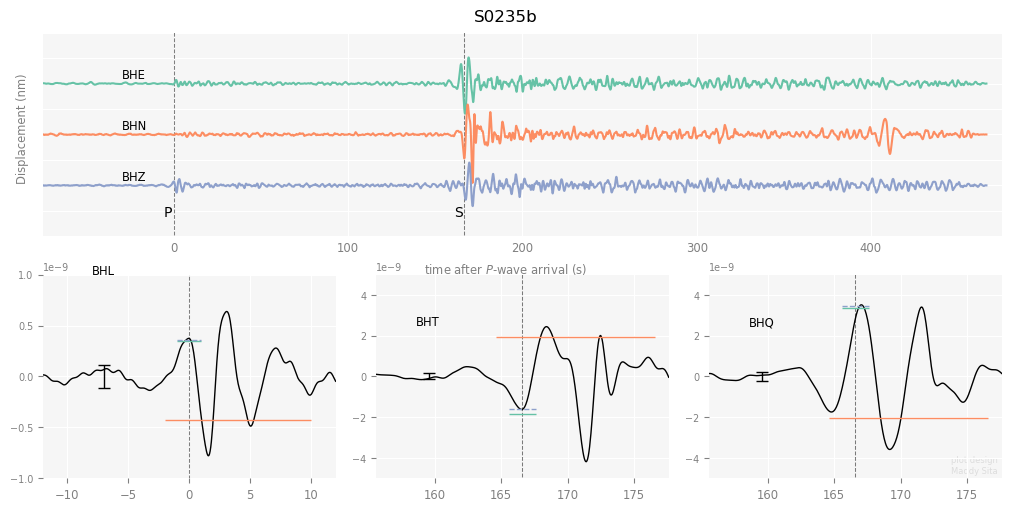

In [10]:
paper_plot_235b(st_uvw, s0235b_fwd,0,166.6,ang_235b,Ptime=Pt)
plt.suptitle('S0235b')


In [11]:
P325a = UTCDateTime('2019-10-26T06:58:57')  # p-wave arrival
S325a = UTCDateTime('2019-10-26T07:02:46')    # s-wave arrival

Pt = UTCDateTime('2019-10-26T06:59:08.23')  # p-wave arrival
St = UTCDateTime('2019-10-26T07:02:59.9')  # s-wave arrival

Pst = UTCDateTime('2019-10-26T06:59:04.8')
Pend = UTCDateTime('2019-10-26T06:59:11.8')
Sst = UTCDateTime('2019-10-26T07:02:56.88')
Send = UTCDateTime('2019-10-26T07:03:04.42')

begin = Pt - 100
end = St + 200

P_begin = Pst - Pt; P_end = Pend - Pt; Pdiff = Pend - Pst
S_begin = Sst - Pt; S_end = Send - Pt; Sdiff = Send - Sst

ang_325a = [319,24.3,22.3]

st_uvw = waveforms(begin, end, 100)

this is P:  -1.32e-09
this is SH:  2.5e-10
this is SV:  -4e-09
this is the scale value:  1.5648367723717975e-09


Text(0.5, 0.98, 'S0325ab')

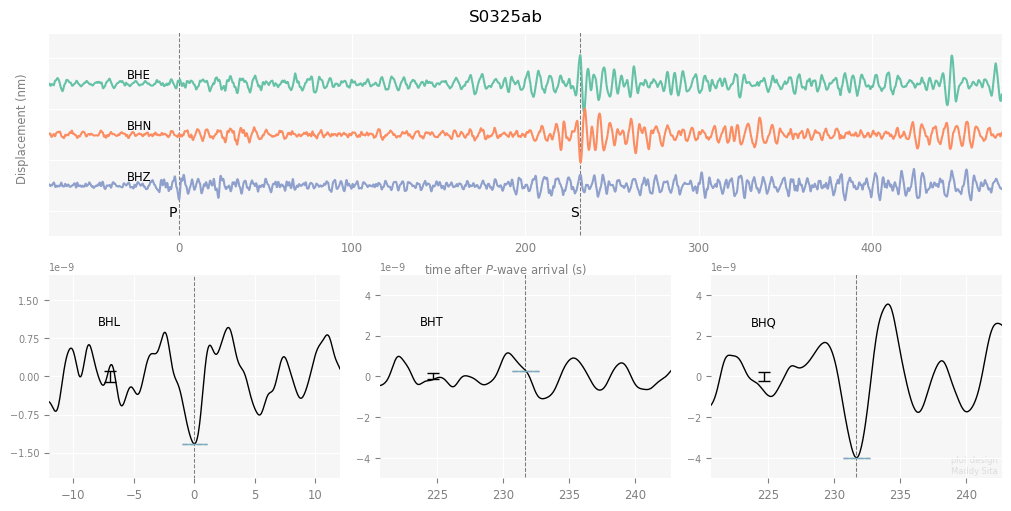

In [12]:
paper_plot(st_uvw, s0325ab_fwd,0,231.7,ang_325a,Ptime=Pt)
plt.suptitle('S0325ab')

this is P:  -1.19e-09
this is SH:  -3.1e-10
this is SV:  9.55e-10
this is the scale value:  1.2454181093324095e-09


Text(0.5, 0.98, 'S0173a')

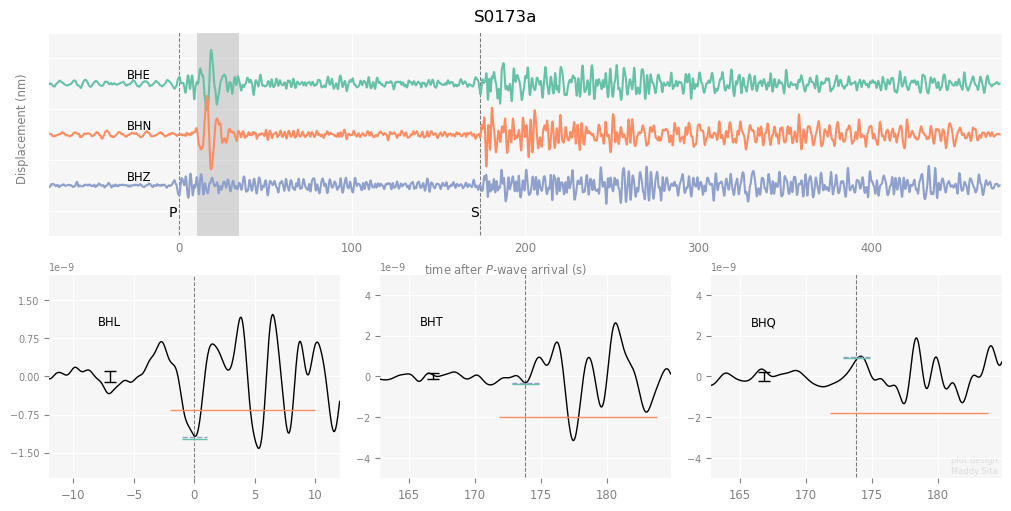

In [13]:
P173a = UTCDateTime('2019-05-23T02:22:59')
S173a = UTCDateTime('2019-05-23T02:25:53')

Pt = UTCDateTime('2019-05-23T02:22:59.48')  # p-wave arrival
St = UTCDateTime('2019-05-23T02:25:53.3')  # s-wave arrival

Pst = UTCDateTime('2019-05-23T02:22:59') - 2
Pend = Pt + 10
Sst = UTCDateTime('2019-05-23T02:25:54') - 2
Send = Sst + 10

begin = Pt - 100
end = St + 200

P_begin = Pst - Pt; P_end = Pend - Pt; Pdiff = Pend - Pst
S_begin = Sst - Pt; S_end = Send - Pt; Sdiff = Send - Sst

ang_173a = [270,25.9,23.4]

st_uvw = waveforms(begin, end, 100)

paper_plot_173(st_uvw, s0173a_fwd,0,173.8,ang_173a,Ptime=Pt)
plt.suptitle('S0173a')

In [14]:
P173ab = UTCDateTime('2019-05-23T02:23:03.3')  # p-wave arrival
S173ab = UTCDateTime('2019-05-23T02:25:56.87')    # s-wave arrival

Pt = UTCDateTime('2019-05-23T02:23:03.3')  # p-wave arrival
St = UTCDateTime('2019-05-23T02:25:56.87')  # s-wave arrival

Pst = UTCDateTime('2019-05-23T02:23:02.01')
Pend = UTCDateTime('2019-05-23T02:23:04.7')

Sst = UTCDateTime('2019-05-23T02:25:53.63')
Send = UTCDateTime('2019-05-23T02:25:59.39')

begin = P173ab - 100
end = S173ab + 200

ang_173ab = [266,25.9,23.4]

st_uvw = waveforms(begin, end, 100)

this is P:  1.15e-09
this is SH:  -3.2e-09
this is SV:  -1.3e-09
this is the scale value:  1.269127359431812e-09


Text(0.5, 0.98, 'S0173ab')

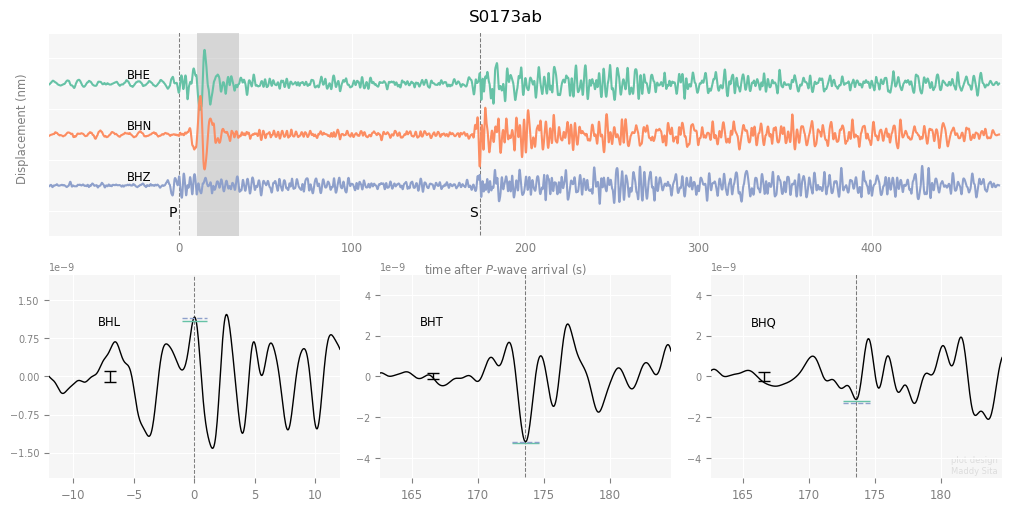

In [15]:
paper_plot_173(st_uvw, s0173ab_fwd,0,173.6,ang_173ab,Ptime=Pt)
plt.suptitle('S0173ab')

In [16]:
P325aa = UTCDateTime('2019-10-26T06:58:57')  # p-wave arrival
S325aa = UTCDateTime('2019-10-26T07:02:46')    # s-wave arrival

Pt = UTCDateTime('2019-10-26T06:58:58.0')  # p-wave arrival
St = UTCDateTime('2019-10-26T07:02:49.3')  # s-wave arrival

Pst = Pt - 2
Pend = Pt + 10
Sst = St - 2
Send = St + 10

begin = Pt - 100
end = St + 300

P_begin = Pst - Pt; P_end = Pend - Pt; Pdiff = Pend - Pst
S_begin = Sst - Pt; S_end = Send - Pt; Sdiff = Send - Sst

ang_325aa = [303,24.3,22.3]

st_uvw = waveforms(begin, end, 100)

In [17]:
s0325aa_fwd = pd.read_csv('./fwdcalc/fwdcalc-325aa.csv',header=None)
s0325aa_fwd.columns = ['ModIndex','Model','Depth','Strike', 'Dip', 'Rake', 'P', 'SV', 'SH']

this is P:  5.38e-10
this is SH:  -9.63e-10
this is SV:  -1.44e-09
this is the scale value:  6.85531170040369e-10


Text(0.5, 0.98, 'S0325a')

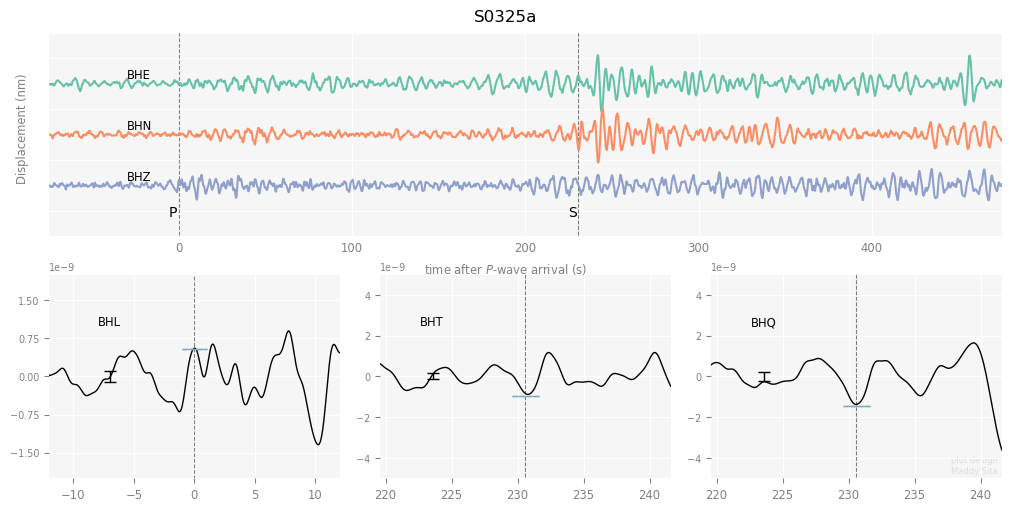

In [18]:
paper_plot(st_uvw, s0325aa_fwd,0,230.6, ang_325aa,Ptime=Pt)
plt.suptitle('S0325a')

In [19]:
def paper_plot_LQT(st,df,Pt,St,angs,Ptime=0):
    if Ptime == 0: Ptime = st[0].stats.starttime
    time_axis = st[0].times(reftime=Ptime)
    n = min([len(time_axis)]+[len(st[i].data) for i in np.arange(len(st))])

    sENZ = uvw2enz(st,angs)
    shift = 5; a = 1e-9
    
    ### FIG PARAM ###
    fig = plt.figure(figsize=(10,3),constrained_layout=True,frameon=False)
    colors = cycler('color',
                    ['#66c2a6', '#fc8d62',
                     '#8ea0cb', '#e889c3', '#a6d855'])
    plt.rc('axes', facecolor='#F6F6F6', edgecolor='none',
           axisbelow=True, grid=True, prop_cycle=colors)
    plt.rc('grid', color='w', linestyle='solid')
    plt.rc('xtick', color='grey', direction='out', labelsize='small'); plt.rc('ytick', color='grey', direction='out', labelsize='x-small')
    fig.patch.set_facecolor('white')
    

    ### SUBPLOT PARAM ###
    gs = GridSpec(1,3, figure = fig)

    ax2 = fig.add_subplot(gs[:, 0:1])
    ax2.set_ylim(-2e-9,2e-9); ax2.set_xlim(-12,12)
    ax2.set_yticks([-1.5e-9,-0.75e-9,0,0.75e-9,1.5e-9])
    
    ax3 = fig.add_subplot(gs[:, 1:2]) 
    ax3.set_ylim(-5e-9,5e-9); ax3.set_xlim(St-11,St+11)
    
    ax4 = fig.add_subplot(gs[:, 2:3]) 
    ax4.set_ylim(-5e-9,5e-9); ax4.set_xlim(St-11,St+11)
    
    
    ### SUBPLOT ANNOTATIONS ###
    ax2.vlines(Pt,-6*a,16*a,color='k',linestyle='--',lw = 0.75,alpha=0.5)
    ax2.errorbar(Pt-7, 0, yerr=1.75e-10, capsize=4, ecolor='k', elinewidth=1)
    
    ax3.vlines(St,-6*a,16*a,color='k',linestyle='--',lw = 0.75,alpha=0.5)
    ax3.errorbar(St-7, 0, yerr=4.79e-10, capsize=4, ecolor='k', elinewidth=1)

    
    ax4.vlines(St,-6*a,16*a,color='k',linestyle='--',lw = 0.75,alpha=0.5)
    ax4.errorbar(St-7, 0, yerr=4.25e-10, capsize=4, ecolor='k', elinewidth=1)

    
    for trace in sENZ:            
    #### P - BHL ####
        if trace.stats.channel == 'BHL':
            ax2.plot(time_axis[:n], trace.data[:n], lw=1, label = trace.stats.channel,color = 'k')
            ax2.annotate('BHL', xy=(Pt-8,1*a), size='small', color='k')
            ax2.set_ylabel("Displacement (nm)", color='grey',fontsize='small')
            
    #### SH - BHL ####
        if trace.stats.channel == 'BHT':
            ax3.plot(time_axis[:n], trace.data[:n], lw=1, label = trace.stats.channel, color='k')
            ax3.annotate('BHT', xy=(St-8,2.5*a), size='small', color='k')
            ax3.set_xlabel("time after $P$-wave arrival (sec)",color ='grey',fontsize='small')
            
    #### SV - BHL ####
        if trace.stats.channel == 'BHQ':
            ax4.plot(time_axis[:n], trace.data[:n], lw=1, label = trace.stats.channel, color='k')
            ax4.annotate('BHQ', xy=(St-8,2.5*a), size='small', color='k')
            
            
    ### AMPS ###
    for index,row in df.iterrows():
        if df['Model'][index] == 'NewGudkova':
            c = '#66c2a6'; liwi = 1; linest = '-'; alp = 1; a = 1e-9
            P_begin = Pt - 1; P_end = Pt + 1 
            S_begin = St - 1; S_end = St + 1
        elif df['Model'][index] == 'OurPick':
            c = '#8ea0cb'; liwi = 0; linest = '-'; alp = 1; a = 0
            P_begin = Pt - 1; P_end = Pt + 1 
            S_begin = St - 1; S_end = St + 1
        elif df['Model'][index] == 'InSightMod':
            c = '#fc8d62'; liwi = 1; linest = '-'; alp = 1; a = 1e-9
            P_begin = Pt - 1; P_end = Pt + 1 
            S_begin = St - 1; S_end = St + 1
        elif df['Model'][index] == 'InSightPick':
            c = '#8ea0cb'; liwi = 1; linest = '-'; alp = 1; a = 1
            P_begin = Pt - 1; P_end = Pt + 1 
            S_begin = St - 1; S_end = St + 1


        #horizontal model lines
        ax2.hlines(df['P'][index]*a,P_begin,P_end,color=c,linestyle=linest,lw=liwi,alpha=alp)
        ax3.hlines(df['SH'][index]*a,S_begin,S_end,color=c,linestyle=linest,lw=liwi,alpha=alp)
        ax4.hlines(df['SV'][index]*a,S_begin,S_end,color=c,linestyle=linest,lw=liwi,alpha=alp)

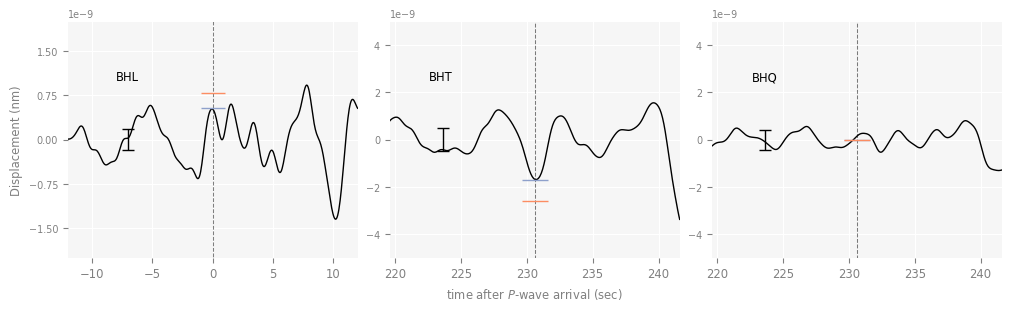

In [20]:
ang_325a_ins = [237,24.3,22.3]

obs_ins = {'Model':'InSightPick', 'P': 5.377e-10, 'SH':-1.69e-9, 'SV':0}
mod_ins = {'Model':'InSightMod', 'P': 0.794412, 'SH':-2.610551, 'SV':-0.00368}
ins_amps = pd.DataFrame([obs_ins, mod_ins])

st_uvw = waveforms(begin, end, 100)
paper_plot_LQT(st_uvw, ins_amps,0,230.6, ang_325a_ins,Ptime=Pt)
# plt.suptitle('S0325a')

In [21]:
def waveforms_COR(start, end, adjtime):
    st_raw = client.get_waveforms('IU', 'COR', '00', "B*", start-adjtime, end+adjtime, attach_response=True)
    st = st_raw.copy()
    st_filt = st.filter('lowpass', freq = 0.1)
    st_disp = st_filt.remove_response(output='DISP')
    # st_disp.plot()
    return st_disp

def rot2enz_COR(st,angles):
    BAz = angles[0]
    Pincd = angles[1]
    Sincd = angles[2]

    if len(st) != 3:
       print('Stream does not contain 3 Traces')
       return st
    for trace in st:
        head = trace.stats
        channel = head.channel
        if channel == 'BH1': one = trace.data
        elif channel == 'BH2': two = trace.data
        elif channel == 'BHZ': Z = trace.data
        else:
            print('Trace.channel is not BH1, BH2, or BHZ')
            return st

    E,N = rotate(two, one, -130)

    head.channel = 'BHE'; trE = Trace(data=E, header=head)
    head.channel = 'BHN'; trN = Trace(data=N, header=head)
    head.channel = 'BHZ'; trZ = Trace(data=Z, header=head)
    stENZ = Stream(traces=[trE,trN,trZ])
    
    hhe = stENZ[0].data
    hhn = stENZ[1].data
    hhz = stENZ[2].data
    
    hhT,hhR = rotate(trE,trN,BAz+180)
    head.channel = 'BHT'; trT = Trace(data=hhT, header=head)
    head.channel = 'BHR'; trR = Trace(data=hhR, header=head)
    
    phhQ,phhL = rotate(trR,trZ,Pincd)
    shhQ,shhL = rotate(trR,trZ,Sincd)
    head.channel = 'BHL'; trL = Trace(data=phhL, header=head)
    head.channel = 'BHQ'; trQ = Trace(data=shhQ, header=head)
    
    stALL = Stream(traces=[trE,trN,trZ,trT,trR,trL,trQ])

    return stALL

def paper_plot_COR(st,df,Pt,St,angs,Ptime=0):
    if Ptime == 0: Ptime = st[0].stats.starttime
    time_axis = st[0].times(reftime=Ptime)
    n = min([len(time_axis)]+[len(st[i].data) for i in np.arange(len(st))])

    sENZ = rot2enz_COR(st,angs)

    shift = 17; a = 1e-7
    
    ### FIG PARAM ###
    fig = plt.figure(figsize=(10,5),constrained_layout=True,frameon=False)
    colors = cycler('color',
                    ['#66c2a6', '#fc8d62',
                     '#8ea0cb', '#e889c3', '#a6d855'])
    plt.rc('axes', facecolor='#F6F6F6', edgecolor='none',
           axisbelow=True, grid=True, prop_cycle=colors)
    plt.rc('grid', color='w', linestyle='solid')
    plt.rc('xtick', color='grey', direction='out', labelsize='small'); plt.rc('ytick', color='grey', direction='out', labelsize='x-small')
    fig.patch.set_facecolor('white')
    
    fig.text(0.5,0.51, "time after $P$-wave arrival (s)", ha="center", va="center_baseline", color ='grey',fontsize='small')
    fig.text(0.01,0.65, "Displacement (m)", rotation=90, color='grey',fontsize='small')
    cms = AnchoredText("plot design\nMaddy Sita", loc="lower right", borderpad=0, frameon=False, prop=dict(size=6,alpha=0.1))
    cms.set_zorder(0)
    
    ### SUBPLOT PARAM ###
    gs = GridSpec(2,3, figure = fig)
    ax1 = fig.add_subplot(gs[0,:]); ax1.set_ylim(-20*a,60*a); ax1.set_xlim(-75,550)
    ax1.tick_params(labelleft=False, length=0)

    ax2 = fig.add_subplot(gs[1, 0:1])
    ax2.set_ylim(-40*a,40*a); ax2.set_xlim(-12,12)
    
    ax3 = fig.add_subplot(gs[1, 1:2]) 
    ax3.set_ylim(-40*a,40*a); ax3.set_xlim(St-11,St+11)
    
    ax4 = fig.add_subplot(gs[1, 2:3]); ax4.add_artist(cms)
    ax4.set_ylim(-40*a,40*a); ax4.set_xlim(St-11,St+11)
    
    
    ### SUBPLOT ANNOTATIONS ###
    ax1.vlines(Pt,-20*a,60*a,color='k',linestyle='--',lw = 0.75,alpha=0.5)
    ax1.annotate('P', xy=(Pt-10,-10*a), size='medium', color='k')
    ax1.vlines(St,-20*a,60*a,color='k',linestyle='--',lw = 0.75,alpha=0.5)
    ax1.annotate('S', xy=(St-10,-10*a), size='medium', color='k')
    
    ax2.vlines(Pt,-40*a,40*a,color='k',linestyle='--',lw = 0.75,alpha=0.5)
    ax2.errorbar(Pt-7, 0, yerr=1.01e-07, capsize=4, ecolor='k', elinewidth=1)
    
    ax3.vlines(St,-40*a,40*a,color='k',linestyle='--',lw = 0.75,alpha=0.5)
    ax3.errorbar(St-7, 0, yerr=2.8e-07, capsize=4, ecolor='k', elinewidth=1)

    
    ax4.vlines(St,-40*a,40*a,color='k',linestyle='--',lw = 0.75,alpha=0.5)
    ax4.errorbar(St-7, 0, yerr=2.76e-07, capsize=4, ecolor='k', elinewidth=1)

    
    for trace in sENZ:
    #### ENZ ####
        if trace.stats.channel == 'BHZ':
            ax1.plot(time_axis[:n], trace.data[:n], lw=1.5, label = trace.stats.channel)
            ax1.annotate('BHZ', xy=(Pt-30,1*a), size='small', color='k')
        if trace.stats.channel == 'BHN':
            ax1.plot(time_axis[:n], trace.data[:n] + shift*a, lw=1.5, label = trace.stats.channel)
            ax1.annotate('BHN', xy=(Pt-30,18*a), size='small', color='k')
        if trace.stats.channel == 'BHE':
            ax1.plot(time_axis[:n], trace.data[:n] + 2*shift*a, lw=1.5, label = trace.stats.channel)
            ax1.annotate('BHE', xy=(Pt-30,35*a), size='small', color='k')
            
    #### P - BHL ####
        if trace.stats.channel == 'BHL':
            ax2.plot(time_axis[:n], trace.data[:n], lw=1, label = trace.stats.channel,color = 'k')
            ax2.annotate('BHL', xy=(Pt-8,10*a), size='small', color='k')
            
    #### SH - BHL ####
        if trace.stats.channel == 'BHT':
            ax3.plot(time_axis[:n], trace.data[:n], lw=1, label = trace.stats.channel, color='k')
            ax3.annotate('BHT', xy=(St-8,10*a), size='small', color='k')
            
    #### SV - BHL ####
        if trace.stats.channel == 'BHQ':
            ax4.plot(time_axis[:n], trace.data[:n], lw=1, label = trace.stats.channel, color='k')
            ax4.annotate('BHQ', xy=(St-8,10*a), size='small', color='k')

    ### AMPS ###
    for index,row in df.iterrows():
        if df['Model'][index] == 'iasp91-COR':
            c = '#fc8d62'; liwi = 1; linest = '-'; alp = 1
            synth = [0.206375, -0.313537, -0.293943]
            obs = [1.54e-06, -2.19e-06, -2.34e-06]

            A_o = np.sqrt(obs[0]**2 + obs[1]**2 + obs[2]**2)

            A_s = np.sqrt(synth[0]**2 + synth[1]**2 + synth[2]**2)

            rat = A_o/A_s
            
        elif df['Model'][index] == 'iasp91-ANMO':
            c = '#66c2a6'; liwi = 1; linest = '-'; alp = 1
            synth = [0.306913, -0.813469, -0.459511]
            obs = [1.54e-06, -2.19e-06, -2.34e-06]

            A_o = np.sqrt(obs[0]**2 + obs[1]**2 + obs[2]**2)

            A_s = np.sqrt(synth[0]**2 + synth[1]**2 + synth[2]**2)

            rat = A_o/A_s
            
        elif df['Model'][index] == 'OurPicks':
            c = '#8ea0cb'; liwi = 1; linest = '--'; alp = 1
            rat = 1

        #horizontal model lines
        ax2.hlines(rat*df['P'][index],Pt-2,Pt+2,color=c,linestyle=linest,lw=liwi,alpha=alp)
        ax3.hlines(rat*df['SH'][index],St-2,St+2,color=c,linestyle=linest,lw=liwi,alpha=alp)
        ax4.hlines(rat*df['SV'][index],St-2,St+2,color=c,linestyle=linest,lw=liwi,alpha=alp)


In [22]:
#COR

event_origin = UTCDateTime('2021-10-10T21:48:36.560')
Pt_COR = UTCDateTime('2021-10-10T21:55:52.7')
St_COR = UTCDateTime('2021-10-10T22:01:45.19')

arrival_diff = abs(Pt_COR-St_COR)

bAz_COR = -123
dist_COR = 37.18
Pa_COR = 26.23
Sa_COR = 27.32

COR_ang = [-123,26.23,27.32]

obs_COR = {'Model':'OurPicks', 'P': 1.56e-06, 'SH':-2.309e-06, 'SV':-2.217e-06}
syn_COR = {'Model':'iasp91-COR', 'P':0.206375, 'SV':-0.293943, 'SH': -0.313537}
COR_amps = pd.DataFrame([obs_COR, syn_COR])

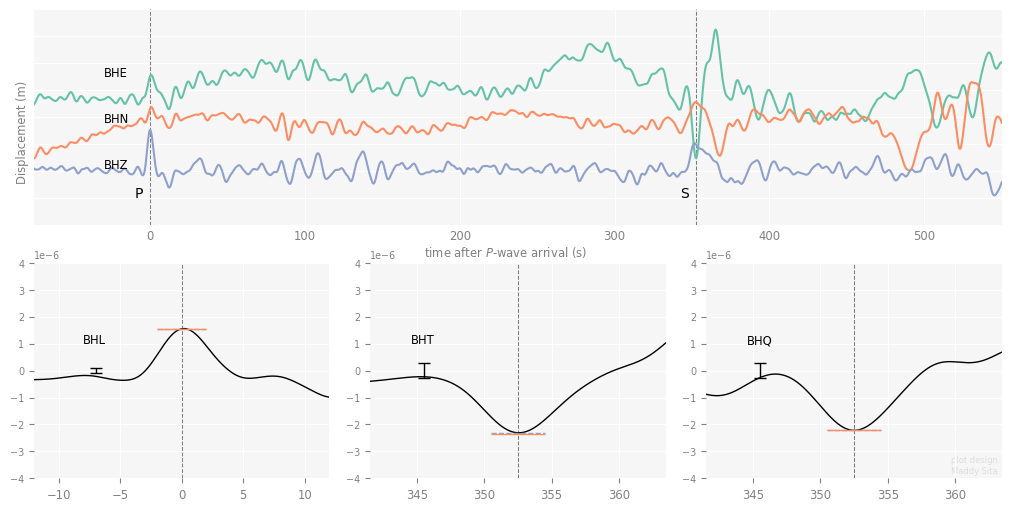

In [23]:
st_z12 = waveforms_COR(Pt_COR,St_COR,800)
paper_plot_COR(st_z12,COR_amps,0,352.49,COR_ang,Ptime=Pt_COR)

In [24]:
def rot2enz_ANMO(st,angles):
    BAz = angles[0]
    Pincd = angles[1]
    Sincd = angles[2]

    if len(st) != 3:
       print('Stream does not contain 3 Traces')
       return st
    for trace in st:
        head = trace.stats
        channel = head.channel
        if channel == 'BH1': one = trace.data
        elif channel == 'BH2': two = trace.data
        elif channel == 'BHZ': Z = trace.data
        else:
            print('Trace.channel is not BH1, BH2, or BHZ')
            return st

    E,N = rotate(two, one, -156)

    head.channel = 'BHE'; trE = Trace(data=E, header=head)
    head.channel = 'BHN'; trN = Trace(data=N, header=head)
    head.channel = 'BHZ'; trZ = Trace(data=Z, header=head)
    stENZ = Stream(traces=[trE,trN,trZ])
    
    hhe = stENZ[0].data
    hhn = stENZ[1].data
    hhz = stENZ[2].data
    
    hhT,hhR = rotate(trE,trN,BAz+180)
    head.channel = 'BHT'; trT = Trace(data=hhT, header=head)
    head.channel = 'BHR'; trR = Trace(data=hhR, header=head)
    
    phhQ,phhL = rotate(trR,trZ,Pincd)
    shhQ,shhL = rotate(trR,trZ,Sincd)
    head.channel = 'BHL'; trL = Trace(data=phhL, header=head)
    head.channel = 'BHQ'; trQ = Trace(data=shhQ, header=head)
    
    stALL = Stream(traces=[trE,trN,trZ,trT,trR,trL,trQ])

    return stALL

def waveforms_ANMO(start, end, adjtime):
    st_raw = client.get_waveforms('IU', 'ANMO', '00', 'B*', start-adjtime, end+adjtime, attach_response=True)
    st = st_raw.copy()
    st_filt = st.filter('lowpass', freq = 0.1)
    st_disp = st_filt.remove_response(output='DISP')
    return st_disp

In [25]:
def paper_plot_ANMO(st,df,Pt,St,angs,Ptime=0):
    if Ptime == 0: Ptime = st[0].stats.starttime
    time_axis = st[0].times(reftime=Ptime)
    n = min([len(time_axis)]+[len(st[i].data) for i in np.arange(len(st))])

    sENZ = rot2enz_ANMO(st,angs)

    shift = 17; a = 1e-7
    
    ### FIG PARAM ###
    fig = plt.figure(figsize=(10,5),constrained_layout=True,frameon=False)
    colors = cycler('color',
                    ['#66c2a6', '#fc8d62',
                     '#8ea0cb', '#e889c3', '#a6d855'])
    plt.rc('axes', facecolor='#F6F6F6', edgecolor='none',
           axisbelow=True, grid=True, prop_cycle=colors)
    plt.rc('grid', color='w', linestyle='solid')
    plt.rc('xtick', color='grey', direction='out', labelsize='small'); plt.rc('ytick', color='grey', direction='out', labelsize='x-small')
    fig.patch.set_facecolor('white')
    
    fig.text(0.5,0.51, "time after $P$-wave arrival (s)", ha="center", va="center_baseline", color ='grey',fontsize='small')
    fig.text(0.01,0.65, "Displacement (m)", rotation=90, color='grey',fontsize='small')
    cms = AnchoredText("plot design\nMaddy Sita", loc="lower right", borderpad=0, frameon=False, prop=dict(size=6,alpha=0.1))
    cms.set_zorder(0)

    ### SUBPLOT PARAM ###
    gs = GridSpec(2,3, figure = fig)
    ax1 = fig.add_subplot(gs[0,:]); ax1.set_ylim(-20*a,60*a); ax1.set_xlim(-75,550)
    ax1.tick_params(labelleft=False, length=0)

    ax2 = fig.add_subplot(gs[1, 0:1])
    ax2.set_ylim(-40*a,40*a); ax2.set_xlim(-12,12)
    
    ax3 = fig.add_subplot(gs[1, 1:2]) 
    ax3.set_ylim(-40*a,40*a); ax3.set_xlim(St-11,St+11)
    
    ax4 = fig.add_subplot(gs[1, 2:3]); ax4.add_artist(cms)
    ax4.set_ylim(-40*a,40*a); ax4.set_xlim(St-11,St+11)
    
    
    ### SUBPLOT ANNOTATIONS ###
    ax1.vlines(Pt,-20*a,60*a,color='k',linestyle='--',lw = 0.75,alpha=0.5)
    ax1.annotate('P', xy=(Pt-10,-10*a), size='medium', color='k')
    ax1.vlines(St,-20*a,60*a,color='k',linestyle='--',lw = 0.75,alpha=0.5)
    ax1.annotate('S', xy=(St-10,-10*a), size='medium', color='k')
    
    ax2.vlines(Pt,-40*a,40*a,color='k',linestyle='--',lw = 0.75,alpha=0.5)
    ax2.errorbar(Pt-7, 0, yerr=1.01e-07, capsize=4, ecolor='k', elinewidth=1)
    
    ax3.vlines(St,-40*a,40*a,color='k',linestyle='--',lw = 0.75,alpha=0.5)
    ax3.errorbar(St-7, 0, yerr=2.8e-07, capsize=4, ecolor='k', elinewidth=1)

    
    ax4.vlines(St,-40*a,40*a,color='k',linestyle='--',lw = 0.75,alpha=0.5)
    ax4.errorbar(St-7, 0, yerr=2.76e-07, capsize=4, ecolor='k', elinewidth=1)

    
    for trace in sENZ:
    #### ENZ ####
        if trace.stats.channel == 'BHZ':
            ax1.plot(time_axis[:n], trace.data[:n], lw=1.5, label = trace.stats.channel)
            ax1.annotate('BHZ', xy=(Pt-30,1*a), size='small', color='k')
        if trace.stats.channel == 'BHN':
            ax1.plot(time_axis[:n], trace.data[:n] + shift*a, lw=1.5, label = trace.stats.channel)
            ax1.annotate('BHN', xy=(Pt-30,18*a), size='small', color='k')
        if trace.stats.channel == 'BHE':
            ax1.plot(time_axis[:n], trace.data[:n] + 2*shift*a, lw=1.5, label = trace.stats.channel)
            ax1.annotate('BHE', xy=(Pt-30,35*a), size='small', color='k')
            
    #### P - BHL ####
        if trace.stats.channel == 'BHL':
            ax2.plot(time_axis[:n], trace.data[:n], lw=1, label = trace.stats.channel,color = 'k')
            ax2.annotate('BHL', xy=(Pt-8,10*a), size='small', color='k')
            
    #### SH - BHL ####
        if trace.stats.channel == 'BHT':
            ax3.plot(time_axis[:n], trace.data[:n], lw=1, label = trace.stats.channel, color='k')
            ax3.annotate('BHT', xy=(St-8,10*a), size='small', color='k')
            
    #### SV - BHL ####
        if trace.stats.channel == 'BHQ':
            ax4.plot(time_axis[:n], trace.data[:n], lw=1, label = trace.stats.channel, color='k')
            ax4.annotate('BHQ', xy=(St-8,10*a), size='small', color='k')

    ### AMPS ###
    for index,row in df.iterrows():
        if df['Model'][index] == 'iasp91-COR':
            c = '#fc8d62'; liwi = 1; linest = '-'; alp = 1
            synth = [0.206375, -0.313537, -0.293943]
            obs = [1.54e-06, -2.19e-06, -2.34e-06]

            A_o = np.sqrt(obs[0]**2 + obs[1]**2 + obs[2]**2)

            A_s = np.sqrt(synth[0]**2 + synth[1]**2 + synth[2]**2)

            rat = A_o/A_s
            
        elif df['Model'][index] == 'iasp91-ANMO':
            c = '#66c2a6'; liwi = 1; linest = '-'; alp = 1
            synth = [0.306913, -0.813469, -0.459511]
            obs = [1.54e-06, -2.19e-06, -2.34e-06]

            A_o = np.sqrt(obs[0]**2 + obs[1]**2 + obs[2]**2)

            A_s = np.sqrt(synth[0]**2 + synth[1]**2 + synth[2]**2)

            rat = A_o/A_s
            
        elif df['Model'][index] == 'OurPicks':
            c = '#8ea0cb'; liwi = 1; linest = '--'; alp = 1
            rat = 1

        #horizontal model lines
        ax2.hlines(rat*df['P'][index],Pt-2,Pt+2,color=c,linestyle=linest,lw=liwi,alpha=alp)
        ax3.hlines(rat*df['SH'][index],St-2,St+2,color=c,linestyle=linest,lw=liwi,alpha=alp)
        ax4.hlines(rat*df['SV'][index],St-2,St+2,color=c,linestyle=linest,lw=liwi,alpha=alp)


In [26]:
#ANMO

event_origin = UTCDateTime('2021-10-10T21:48:36.560')
Pt_ANMO = UTCDateTime('2021-10-10T21:57:06.6')
St_ANMO = UTCDateTime('2021-10-10T22:03:59.2')

arrival_diff = abs(Pt_ANMO-St_ANMO)

bAz_ANMO = -97
dist_ANMO = 46.13
Pa_ANMO = 24.24
Sa_ANMO = 25.70

ANMO_ang = [-97,24.24,25.70]

obs_ANMO = {'Model':'OurPicks', 'P': 1.04e-06, 'SH':-2.74e-06, 'SV':-1.55e-06}
syn_ANMO = {'Model': 'iasp91-ANMO', 'P': 0.306913, 'SV':-0.459511, 'SH':-0.813469}
ANMO_amps = pd.DataFrame([obs_ANMO, syn_ANMO])

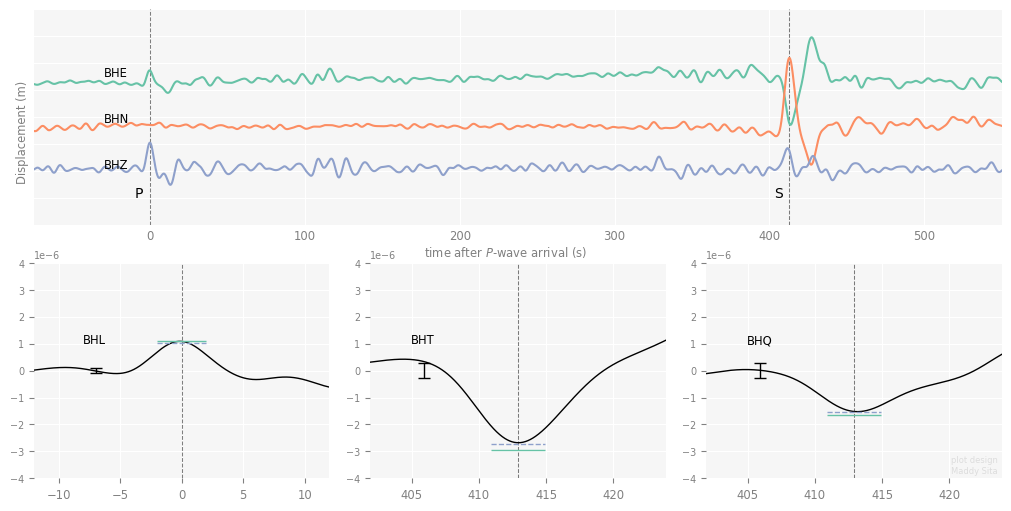

In [27]:
st_z12 = waveforms_ANMO(Pt_ANMO,St_ANMO,800)
paper_plot_ANMO(st_z12,ANMO_amps,0,412.9,ANMO_ang,Ptime=Pt_ANMO)